In [1]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from random import randrange
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

#drive/MyDrive/emnist_data/
drive_path = 'drive/MyDrive/'
path = 'drive/MyDrive/emnist_data/'

In [2]:

def load_mapping(path='data/emnist-balanced-mapping.txt'):
    f=open(path,'r')
    letter_to_label = dict()
    label_to_letter = dict()
    for line in f:
        nums = line.split()
        label = int(nums[0])
        letter = chr(int(nums[1]))
        letter_to_label[letter] = label 
        label_to_letter[label] = letter 
    return label_to_letter, letter_to_label

In [3]:
def load_data(path='data/emnist-balanced.mat'):
    #EMNIST dataset: 28x28 image

    #labels are from 0 to 46 for emnist-balanced
    mat = scipy.io.loadmat(path)
    dataset=mat['dataset']
    train_images = dataset['train'][0,0]['images'][0,0]
    train_labels = dataset['train'][0,0]['labels'][0,0]
    test_images = dataset['test'][0,0]['images'][0,0]
    test_labels = dataset['test'][0,0]['labels'][0,0]

    #reshaping into 28 x 28 images 
    train_images =  np.reshape(train_images, (train_images.shape[0],28,28,1))
    test_images =  np.reshape(test_images, (test_images.shape[0],28,28,1))
    
    # print(type(train_images), train_images.shape, train_labels.shape, test_images.shape )
  

    return  [train_images, train_labels, test_images, test_labels]

In [4]:
def display_image(image, lab2let, label = ''):

    if(not (label=='')): 
        label = lab2let[label] 
    image = np.flip(np.reshape(image, (28,28)), axis=1)
    image = np.rot90(image)

    plt.figure()
    plt.title(label)
    plt.imshow(image, interpolation='nearest')
    plt.show()
       
    # image = np.flip(np.rot90(image,3), axis=1)

    # plt.figure()
    # plt.imshow(image, interpolation='nearest') 
    # plt.show()


In [5]:
#load data
# train_images, train_labels, test_images, test_labels
data_digits = load_data(path+'emnist-digits.mat') #240000, 40000
data_letters = load_data(path+'emnist-letters.mat') #124800, 20800
# data_bal = load_data(path+'emnist-balanced.mat') #112800  #NOTE, emnist-balanced doesn't contain all data labels

In [6]:
#data preprocessing 
#convert labels: digits: 0-9, letters 1-26 ->10-35  
data_letters[1] = np.add(data_letters[1],9)
data_letters[3] = np.add(data_letters[3],9)
print(np.unique(data_letters[1]), np.unique(data_digits[1]))

[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35] [0 1 2 3 4 5 6 7 8 9]


In [7]:
#TODO balance digits and letters data, 
#split digits' training data into about same amount as letters
data_digits[0], d_images, data_digits[1], d_labels = train_test_split(data_digits[0], data_digits[1], test_size=0.5, stratify=data_digits[1])

In [8]:
#combining letters and digits data (stack vertically) 
train_images = np.vstack((data_digits[0], data_letters[0]))
train_labels = np.vstack((data_digits[1], data_letters[1]))
test_images = np.vstack((data_digits[2], data_letters[2]))
test_labels = np.vstack((data_digits[3], data_letters[3]))

#split into validation data (15%)
train_images,val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.15,stratify=train_labels)
print(train_images.shape, test_images.shape,val_images.shape ) 

(208080, 28, 28, 1) (60800, 28, 28, 1) (36720, 28, 28, 1)


In [9]:
#normalize data, image data range from 0 to 255
train_images = train_images/255.0
test_images = test_images/255.0   
val_images = val_images/255.0  

#convert to categorical
num_classes = 36 
train_labels= to_categorical(train_labels, num_classes)
test_labels= to_categorical(test_labels, num_classes)
val_labels= to_categorical(val_labels, num_classes)

In [10]:
def model():
    model=Sequential()
    #activation: softmax
 
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2))
    model.add(Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding = 'same'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=2)) 
    model.add(Flatten()) 
    model.add(Dense(128,activation ="relu"))
    model.add(Dense(36,activation ="softmax"))

    # print(model.summary())
    model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model 

"\n    model = tf.keras.Sequential([ \n    tf.keras.layers.Conv2D(32,3,input_shape=(28,28,1)),\n    tf.keras.layers.MaxPooling2D(2,2),\n    tf.keras.layers.Flatten(input_shape=(28,28,1)),\n    tf.keras.layers.Dense(512,activation='relu'),\n    tf.keras.layers.Dense(128,activation='relu'),\n    tf.keras.layers.Dense(number_of_classes,activation='softmax')\n])"

In [11]:
 
model = model() 

 

#saves model weights
checkpoint_filepath = drive_path + '05618_project/weights/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'  
MCP = ModelCheckpoint(checkpoint_filepath,verbose=1,save_best_only=False,monitor='val_accuracy' ) 

#early stopping when  monitored val stops improving
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3 )

#Reduce learning rate when a metric has stopped improving.
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,min_lr=0.0001)

print(test_images.shape, test_labels.shape, val_images.shape, val_labels.shape)
history = model.fit(train_images, train_labels, epochs=10,  validation_data = (val_images,val_labels),callbacks=[MCP,ES,RLP])

(60800, 28, 28, 1) (60800, 36) (36720, 28, 28, 1) (36720, 36)
Epoch 1/10
6501/6503 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8461
Epoch 00001: saving model to drive/MyDrive/05618_project/weights/weights.01-0.89.hdf5
6503/6503 [==============================] - 204s 31ms/step - loss: 0.4783 - accuracy: 0.8462 - val_loss: 0.3318 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 2/10
6501/6503 [============================>.] - ETA: 0s - loss: 0.3037 - accuracy: 0.8949
Epoch 00002: saving model to drive/MyDrive/05618_project/weights/weights.02-0.89.hdf5
6503/6503 [==============================] - 189s 29ms/step - loss: 0.3037 - accuracy: 0.8949 - val_loss: 0.2986 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 3/10
6501/6503 [============================>.] - ETA: 0s - loss: 0.2624 - accuracy: 0.9071
Epoch 00003: saving model to drive/MyDrive/05618_project/weights/weights.03-0.90.hdf5
6503/6503 [==============================] - 189s 29ms/step - loss: 0.2624 - accuracy: 0

In [12]:
model.summary()
# model.save( drive_path + '05618_project/model_dl_unbalanced.h5') #NOTE remember to change names here

model.save( drive_path + '05618_project/model_dl_balanced_2conv1d.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [13]:
py_test1=model.predict(test_images)

2 2
6 6
12 12
2 2
6 6
7 7
9 9
6 6
35 35
7 7
8 8
1 1
18 21
7 7
0 0
9 9


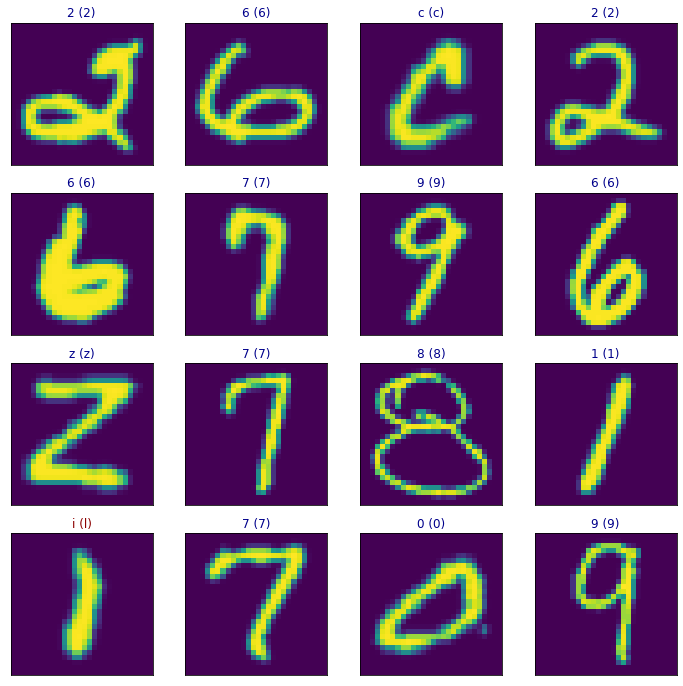

In [14]:
letters ='0123456789abcdefghijklmnopqrstuvwxyz'
letters = list(letters)
fig=plt.figure(figsize=(12,12))
for i,idx in enumerate(np.random.choice(test_images.shape[0],
                                        size=16,replace=False)):
    ax=fig.add_subplot(4,4,i+1,xticks=[],yticks=[])
    image = np.flip(np.reshape(test_images[idx], (28,28)), axis=1)
    image = np.rot90(image) 
    ax.imshow(np.squeeze(image))
    
    pred_idx=np.argmax(py_test1[idx])
    true_idx=np.argmax(test_labels[idx]) 
    ax.set_title("{} ({})".format(letters[pred_idx],letters[true_idx]),
                 color=("darkblue" if pred_idx==true_idx else "darkred"))